<a href="https://colab.research.google.com/github/ibrahimgh25/CutterKit/blob/master/CartPole_qlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This file implements the q-learning algorithm on the 'CartPole-v0' environment provided by the gym package. This is the first thing I actually used q_learning on, (I mean instead of just playing around with someones code), the code is based on a code from pythonprograming.net where they use q_learning to solve the mountain cart problem (link: https://pythonprogramming.net/q-learning-analysis-reinforcement-learning-python-tutorial/), that's actually were I learned to implement the algorithm. But as you might able to guess, alot of tweaking to the algorithm had to be made in order for it to work. I experimented with various parameters, but not a lot with the ceil on the observation space (mentioned in 'adjustObs' function). I also discretisized the whole observation space into the same number of levels, but that can also be tuned by choosing lower number of levels for less important parameters (or ones that aren't affected much with harsh discretization) and higher or same discretization levels for parameters which are more affected. However, further work would be to optimize for faster results - which I haven't done yet, and am even questioning the value of such tweak in this particular problem (why waste much more time to get a faster solution when the faster solution is what you got, you didn't have to spend time optimizing at least)

In [1]:
# The needed imports
import gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

In the next segment two functions that will help our agent are introduced, one is to clip extreme values that we can get from the observation space before discretization, such values can be very troublesome, the continous observation space at locations 1 and 3 can go up to '1e38', which creates problem with the window size especially on the small values, so I decided to clip values above or below a certain thresholds (typically less than a 1000). The second function is just for helping in the naming of saved copies of our agent, it just adds zeros at the begining, perhaps there is a better way to do that but I did what worked, and this probably won't affect the performance of the agent.

In [2]:
def adjustObs(obs, max_value=200.0):
  '''
  Clips the input (obs) to be bound by a max_value
  
  Parameters:
  obs (np.array(int)): an array (typically an observation), we need to make sure 
   there are no funny values in here
  max_value (float): the ceil (and negative of the floor) of the array

  Returns the clipped array
  '''
  return np.clip(obs, -max_value, max_value)

def adjustString(integer_number, intended_digits=5):
  '''
  To return a better formatted number when naming agents, the saved file will
  be identified by the number of episode it was saved on, for example we need 
  the numbering to be 001 002 ... 100 instead of 1 2 ... 100 which will be 
  better visually and sorted correctly everywhere (a lot of systems sort 100 
  before 2 which would be a problem, for my eyes at least)

  Parameters:
  integer_number (int): the number we want formatted
  intended_digits (int): the number of digits we want in the output
  '''
  def count_digits(integer_number):
    # Counts number of digits in given an integer by continously dividing by 10
    number_of_digits = 0
    while integer_number > 10:
      integer_number = integer_number // 10
      number_of_digits += 1
    return number_of_digits
  
  digits = count_digits(integer_number)
  string = ''
  # Here we didn't handle for when the digits of the input number are higher 
  # than the intended digits, we depend on our ability to use the function correctly...
  for _ in range(intended_digits - digits):
    string += '0'
  return string + str(integer_number)

The next cell contains the implementation of the agent. Maybe the agent is a little overkill when it comes to the number of attributes, but I like everything to be easily controlled.

In [12]:
class cartPole_agent():
  '''The agent we're trying to train, it has a lot of attributes, so be ready.
  The reason for that many attributes is for me to try and change everything :)

  Args:
    env (gym.environment): the CartPole-v0 envirnment
    options (int): the number of options available for the agent
    learning_rate (float): alpha, the learning rate
    discount (float): the discount factor, how much to discount future qs
    log (string): the path to where the agent would be saved
    epsilon (float): epsilon to be used with the q-learning greedy policy
    start_epsilon_decaying (int): At which episode epsilon_decaying starts
    stop_epsilon_decaying (int): At which episode epsilon_decaying ends
    epsilon_decay_value (float): The value to subtract from epsilon, stored to 
     save time during training.
    obs_low (:obj:'list' of :obj:'int'): the min obs_space (corrected for extreme
     values), stored to reduce calculation time during discretization
    DISC_OS_SIZE (:obj:'list' of :obj:'int'): size of the discretisized observation
     states, (bucket sizes if you will)
    DISC_OS_WIN_SIZE (:obj:'list' of :obj:'int'):  window size between two discrete
     levels
    q_table (:obj: 'ndarray' of :obj:'float'): our q_values are stored here
    ep_rewards (:obj:'list' of :obj:'int'): the rewards for the current episode
    aggr_ep_rewards (:obj:`list` of :obj:`dict'): contains info 
     about the avg, min, and max of a bunch of grouped episodes
    consecutively_solved (int): the number of times the agent was able to 
     consecutively reach more than 195 rewards

  '''
  def __init__(self, learning_rate=0.1, discount=0.999, epsilon=1,
               start_epsilon_decaying=1, end_epsilon_decaying=30000,
               discretization_levels=20, q_init_low=-1, q_init_high=1):

    self.env = gym.make("CartPole-v0")
    self.options = self.env.action_space.n
    self.learning_rate = learning_rate
    self.discount = discount
    # Name for the log_file where versions of the agent are saved
    self.log = f"agent_log_lr({learning_rate}_discount({discount}_dl({discretization_levels}"
    if not os.path.exists(self.log):
      os.mkdir(self.log)

    self.epsilon = epsilon
    self.start_epsilon_decaying = start_epsilon_decaying
    self.end_epsilon_decaying = end_epsilon_decaying
    # Caculate the value to be subtracted from epsilon at each episode
    decayed_episodes = end_epsilon_decaying - start_epsilon_decaying
    self.epsilon_decay_value = epsilon / decayed_episodes

    obs_high = adjustObs(self.env.observation_space.high)
    obs_low = adjustObs(self.env.observation_space.low)
    # Save obs_low since it's needed in getDiscreteState to avoid calculating it
    # at each iteration
    self.obs_low = obs_low
    # Get the number of states and calculate the window size to be used in 
    # discretization
    self.DISC_OS_SIZE = [discretization_levels] * len(obs_low)
    self.DISC_OS_WIN_SIZE = (obs_high - obs_low)/self.DISC_OS_SIZE
    # Initiate the q_table randomly
    self.q_table = np.random.uniform(low=q_init_low, high=q_init_high,
                                      size=(self.DISC_OS_SIZE + [self.options]))

    self.ep_rewards = []
    self.aggr_ep_rewards = {'ep': [], 'avg': [], 'max': [], 'min': []}
    self.consecutively_solved = 0


  def getAction(self, discrete_state):
    # Returns the action given a discrete state
    if np.random.random() > self.epsilon:
      return np.argmax(self.q_table[discrete_state])
    else:
      return np.random.randint(0, self.options)

  def getDiscreteState(self, state):
    # Returns a discrete state given a continous state
    state = adjustObs(state)
    discrete_state = (state - self.obs_low) / self.DISC_OS_WIN_SIZE
    return tuple(discrete_state.astype(int))

  def playOnce(self, episode, stats_every=200, suppress_output=False,
               save_every=500):
    '''
    Performs one iteration of the q_learning algorithms and updates the q_values
    
    Parameters:
    episode (int): at which episode of training are we (used for updating avg tables,
     saving images of the agent, and knowing when to output the results of training)
    stats_every (int): the frequency at which aggr_ep_rewards list is updated
    suppress_output (int): if True no the model isn't saved and the results aren't shown
     on the screen (useful when you want to quickly compare different hyper params)
    save_every (int): the frequency at which to save an image of the agent

    The function directly updates the elements of the class object and has no return value
    '''
    done = False
    discrete_state = self.getDiscreteState(self.env.reset())
    episode_reward = 0
    steps = 0

    while not done:
      action = self.getAction(discrete_state)
      new_state, reward, done, _ = self.env.step(action)
      steps = steps + 1
      episode_reward += reward
      new_discrete_state = self.getDiscreteState(new_state)

      if not done: # Typical q_learning algorithm
        max_future_q = np.max(self.q_table[new_discrete_state])
        current_q = self.q_table[discrete_state + (action, )]
        new_q = (
            (1 - self.learning_rate) * current_q 
            + self.learning_rate * (reward + self.discount * max_future_q)
            )
        self.q_table[discrete_state + (action, )] = new_q

      else:
        if steps > 195: # Update the consecutively_solved counter if needed
          self.consecutively_solved = self.consecutively_solved + 1
        else: # else reset the consecutively_solved counter
          self.consecutively_solved = 0
        # The following line is actually what makes the agent break to high results
        # when you start, you start zeroing out the q for the moves that make you 
        # lose, but in the long run this destroys your table, so after a while training,
        # you keep q as is (when epsilon is 0).
        self.q_table[discrete_state + (action, )] *= (1 - self.epsilon)
 
      discrete_state = new_discrete_state
    # Decay epsilon
    if self.end_epsilon_decaying >= episode >= self.start_epsilon_decaying:
        self.epsilon -= self.epsilon_decay_value
    # Add episode reward is added to the reward-set of the agent
    self.ep_rewards.append(episode_reward)
    if not episode % stats_every and not episode == 0:
      average_reward = sum(self.ep_rewards[-stats_every:])/stats_every
      self.aggr_ep_rewards['ep'].append(episode)
      self.aggr_ep_rewards['avg'].append(average_reward)
      self.aggr_ep_rewards['max'].append(max(self.ep_rewards[-stats_every:]))
      self.aggr_ep_rewards['min'].append(min(self.ep_rewards[-stats_every:]))
      if not suppress_output:
        print(f'Episode: {episode:>5d}, average reward: {average_reward:>4.1f}, current epsilon: {self.epsilon:>1.2f}')

    # Save an image of the agent I was doing that because the problem wasn't solved
    # yet, but after it was solved, I don't think it's necessary
    # if not episode % save_every and not suppress_output and not episode == 0:
    #   file_name = self.log + "/agent_E" + adjustString(episode)
    #   pickle.dump(self, open(file_name, 'wb'))


  def display_results(self):
    '''
    Displays the results of training saved in aggr_ep_rewards, and saves a copy 
    of the graph
    '''
    plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['avg'],
             label="average rewards")
    plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['max'],
             label="max rewards")
    plt.plot(self.aggr_ep_rewards['ep'], self.aggr_ep_rewards['min'],
             label="min rewards")
    plt.legend(loc=1)
    plt.savefig('figure.jpg')
    plt.show()

Now, let's train. Reminder: the problem is considered solved when the agent gets more than 195 for a 100 consecutive episodes. The process is random, I ran it 3 times, one time it was solved in about 46000 episodes, one time it wasn't solved in the set episodes (and didn't seem like it will be solved either), and in the results below, it was solved in  about 35000 episodes. I probably should work to get more consistant results.
ps: I know I can set random seeds, but I think it's better to observe the  algorithm working in varying conditions.

In [15]:
EPISODES = 50_000
# Create the agent and train it for 50_000 episodes
agent = cartPole_agent(learning_rate=0.1, discount=0.999, epsilon=1,
               start_epsilon_decaying=1, end_epsilon_decaying=30_000,
               discretization_levels=32, q_init_low=0, q_init_high=70)
for episode in range(EPISODES):
  agent.playOnce(episode)
  if agent.consecutively_solved == 100:
    print("Congrats! You solved the Cartpole problem in ", episode, " episodes")
    file_name = agent.log + "/agent_E" + adjustString(episode)
    pickle.dump(agent, open(file_name, 'wb'))
    break


Episode:   200, average reward: 22.3, current epsilon: 0.99
Episode:   400, average reward: 23.7, current epsilon: 0.99
Episode:   600, average reward: 23.7, current epsilon: 0.98
Episode:   800, average reward: 23.3, current epsilon: 0.97
Episode:  1000, average reward: 23.7, current epsilon: 0.97
Episode:  1200, average reward: 23.5, current epsilon: 0.96
Episode:  1400, average reward: 24.4, current epsilon: 0.95
Episode:  1600, average reward: 22.5, current epsilon: 0.95
Episode:  1800, average reward: 24.4, current epsilon: 0.94
Episode:  2000, average reward: 23.5, current epsilon: 0.93
Episode:  2200, average reward: 27.0, current epsilon: 0.93
Episode:  2400, average reward: 26.6, current epsilon: 0.92
Episode:  2600, average reward: 24.8, current epsilon: 0.91
Episode:  2800, average reward: 25.2, current epsilon: 0.91
Episode:  3000, average reward: 25.8, current epsilon: 0.90
Episode:  3200, average reward: 28.2, current epsilon: 0.89
Episode:  3400, average reward: 29.3, cu

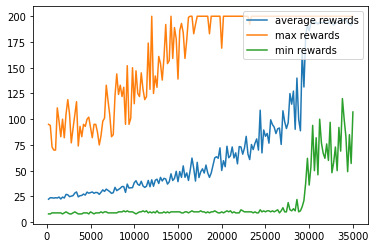

In [16]:
# Plot the results of training, I know the legends are in the way, 
# but I m just too lazy to adjust the function and run the program again...
agent.display_results()

The following cells are the cells where I experimented on my hyper parameters, but I made changes to the algorithm (added * (1 - epsilon)), but I do think the results I got are still relevant, maybe not the optimum but they work. I deleted the results because you would see totally different results when running, and back then I was optimizing for higher results, while now we want to optimize for faster ones.

In [ ]:
# For testing different parameters (when to end epsilon decaying, what effect 
# does changing max initialized q_value on the rewards, and what is the optimal 
# discretization level)

EPISODES = 50_000

end_epsilon_decaying_list = [40_000, 50_000, 30_000]
discretization_levels_list = [20, 26, 32]
q_init_high_list = [50, 60, 70]
results = []
for end_epsilon_decaying in end_epsilon_decaying_list:
  for discretization_level in discretization_levels_list:
    for q_init_high in q_init_high_list:
      play_ground = cartPole_agent(learning_rate=0.1, discount=0.999, epsilon=1,
                                    start_epsilon_decaying=1, end_epsilon_decaying=end_epsilon_decaying,
                                    discretization_levels=discretization_level, q_init_low=0, q_init_high=q_init_high)
    for episode in range(EPISODES):
      play_ground.playOnce(episode, suppress_output=True)
    results.append(([end_epsilon_decaying, discretization_level, q_init_high], play_ground.aggr_ep_rewards))
    # print(play_ground.aggr_ep_rewards['avg'])
    mean = np.nanmean(play_ground.aggr_ep_rewards['avg'])
    print(f'for end_epsilon_decaying={end_epsilon_decaying} and discretization_levels={discretization_level} and q_init_high={q_init_high} average_rewards = {mean}')

In [ ]:
# Viewing more details of the above experiment
for parameters, agg_ep_rewards in results:
  print(parameters, ':')
  print(np.max(agg_ep_rewards['avg']))
  print(np.max(agg_ep_rewards['min']))

In [ ]:
# For testing different parameters (optimal learning_rate, what effect 
# does changing discount_value have on the rewards

discount_list = [0.8, 0.9, 0.95, 0.99, 0.999]
learning_rate_list = [0.1, 0.01, 0.05]
results_2 = []
for discount in discount_list:
  for learning_rate in learning_rate_list:
    play_ground = cartPole_agent(learning_rate=learning_rate, discount=discount, epsilon=1,
                                    start_epsilon_decaying=1, end_epsilon_decaying=30_000,
                                    discretization_levels=32, q_init_low=0, q_init_high=70)
    for episode in range(EPISODES):
      play_ground.playOnce(episode, suppress_output=True)
    results_2.append(([discount, learning_rate], play_ground.aggr_ep_rewards))
    # print(play_ground.aggr_ep_rewards['avg'])
    mean = np.nanmean(play_ground.aggr_ep_rewards['avg'])
    print(f'for learning_rate={learning_rate} and discount={discount} average_rewards = {mean}')

In [ ]:
# Viewing more details of the above experiment
for parameters, agg_ep_rewards in results_2:
  print(parameters, ':')
  print(np.max(agg_ep_rewards['avg']))
  print(np.max(agg_ep_rewards['min']))